In [1]:
import math
from skimage import io, util
import heapq
import sklearn
import Edmon
import Ford
from patchGeneration import *

In [2]:
#takes the following inputs in the below order
#matrix - with inf values
#patchLength - no of rows participating
#overlap - no Of columns in
#leftOfPatch - left side of the patch
#rightOfRes - right of the final image that is already present
#generates an adjacency matrix for a vertical cut
def getVerticalMatrix(matrix,patchLength,overlap,leftOfPatch,rightOfRes):
    for i in range(1,patchLength+1):
            prev = i
            for j in range(0,overlap):
                if(j+1<overlap):                    
                    matrix[prev][prev+patchLength] = abs(getAvg(leftOfPatch[i-1][j]) - getAvg(rightOfRes[i-1][j])) + abs(getAvg(leftOfPatch[i-1][j+1]) - getAvg(rightOfRes[i-1][j+1]))+0.5

                if(i < patchLength):
                   
                    matrix[prev][prev+1] = abs(getAvg(leftOfPatch[i-1][j]) - getAvg(rightOfRes[i-1][j])) + abs(getAvg(leftOfPatch[i][j]) - getAvg(rightOfRes[i][j]))+0.5
                prev = prev+patchLength
    
    return matrix

In [3]:
#takes the following inputs in the below order
#matrix - with inf values
#cols - length of the right Patch
#patchLength - no of rows participating
#overlap - no Of columns in
#patch_up - overlap region from the res matrix
#patch_bottom - overlap region from the bottom matrix
#generates an adjacency matrix for a vertical cut
def getHorizontalMatrix(matrix,patchLength,overlap,patch_up,patch_bottom):
        prev = 1
        for i in range(1,overlap+1):
            for j in range(0,patchLength):
                if(j<patchLength-1):
                    matrix[prev][prev+1] = getAvg(abs(patch_up[i-1][j] - patch_bottom[i-1][j]) + abs(patch_up[i-1][j+1] - patch_bottom[i-1][j+1]))+0.5
                
                if(i<overlap):
                    matrix[prev][prev+patchLength] = getAvg(abs(patch_up[i-1][j] - patch_bottom[i-1][j]) + abs(patch_up[i][j] - patch_bottom[i][j]))+0.5
                prev+=1
    
        return matrix

In [4]:
#returns the average value of the pixel array
def getAvg(pixelArray):
    return (sum(pixelArray)/3)

In [5]:
import matplotlib.pyplot as plt
def minCutPatch(patch, patchLength, overlap, res, y, x,orgImage,algoName,imageName,fileCounter,showGraphCuts):

    patch_copy = patch.copy()
    res_copy = res.copy()
    overlapPatchCopy = patch.copy()
    totalNodes = 0
    
    if x > 0:
        
        #lets define the regions that participate in the overlap regions from the respective patches
        rightOfRes = res_copy[y:y+patchLength,x:x+overlap]
        leftOfPatch = patch_copy[:,:overlap]
      
        totalNodes = (len(rightOfRes) * len(rightOfRes[0]))+2
        
        #initiating the adj matrix
        matrix = []
        for i in range(0,(len(rightOfRes) * len(rightOfRes[0]))+2):
            rows = []
            for j in range(0,(len(rightOfRes) * len(rightOfRes[0]))+2):
                rows.append(0)
            matrix.append(rows)

        #assigning infinities to the nodes that are neighbours of source and sink
        for i in range(1,len(rightOfRes)+1):
            matrix[0][i] = float('inf')
        for i in range(25*(overlap-1)+1,totalNodes-1):
            matrix[i][totalNodes-1] = float('inf')


        #assigning values in the adjacency matrix
        matrix = getVerticalMatrix(matrix,patchLength,overlap,leftOfPatch,rightOfRes)


        #Writing the matrix into files as imagename+filcounter+_typeOfCut+Algo
        fileStr ='Adjancency Matrixs/'+(str)(imageName)+(str)(fileCounter)+"_Vertical"+(str)(algoName)+".txt"
        with open(fileStr, 'w') as f:
            for i in range(0,len(matrix)):
                for j in range(0,len(matrix[0])):
                    f.write(str(matrix[i][j]))
                    f.write(" ")
                f.write("\n")
        
        left_pixels  = []
        right_pixels = []
        
        if algoName == "Edmond":
        #passing the adjacency matrix to the edmon algorithm, which returns edges that had a cut and a visited array
            #print("Going for Edmond")
            algo_obj = Edmon.EdmonKarps(matrix)
            source = 0; sink = totalNodes-1
            left_pixels ,right_pixels,visited = algo_obj.minCut(source, sink)
        else:
            #print("Going for Karps")
            algo_obj = Ford.FordK()
            source = 0; sink = totalNodes-1
            left_pixels,right_pixels,visited = algo_obj.getMinCut(matrix,source, sink)
        
        #write the edges into the file
        fileStr ='Pixel Vectors/'+(str)(imageName)+(str)(fileCounter)+"_Vertical"+(str)(algoName)+".txt"
        with open(fileStr, 'w') as f:
            for i in range(0,len(left_pixels)):
                    f.write(str(left_pixels[i]))
                    f.write("-")
                    f.write(str(right_pixels[i]))
                    f.write("\n")

        #now swap the patch values as needed and overlapPatchCopy helps us in generating overlap image
        indexCounter = 1
        for i in range(0,overlap):
            for j in range(0,patchLength):
                
                if visited[indexCounter] == True:
                    patch_copy[j][i] = leftOfPatch[j][i]
                    overlapPatchCopy[j][i] = [255,0,0]
                else:
                    overlapPatchCopy[j][i] = [255,255,255]
                indexCounter+=1
        
        #if this variable is set to true, then we show the graph cuts happening        
        if showGraphCuts == True:
            # creating a matrix in the shape of overlap region
            #differentiating the regions from two patches by asssigning green an white color
            #green - from up/left(source) patch , white - from right/down(sink) patch
            ctr = 1
            minCutMatrix = []
            for i in range(0,patchLength):
                colorsRow = []
                for j in range(0,overlap):
                        colorsRow.append(2)
                minCutMatrix.append(colorsRow)

            for i in range(0,overlap):
                for j in range(0,patchLength):
                    if visited[ctr] == True:
                        minCutMatrix[j][i] = 1
                    ctr+=1

            fig, ax = plt.subplots()
            ax.matshow(minCutMatrix, cmap='ocean')
            plt.show()
        
    
    if y > 0:

        #lets define the regions that participate in the overlap regions from the respective patches
        matrix = []
        patch_up = res_copy[y:(y+overlap),x:x+patchLength]
        patch_bottom = patch_copy[:overlap,:]
        

        for i in range(0,(len(patch_up) * len(patch_up[0]))+2):
            rows = []
            for j in range(0,(len(patch_up) * len(patch_up[0]))+2):
                rows.append(0)
            matrix.append(rows)
        
        
        #assigning infinities to the nodes that are neighbours of source and sink        
        for i in range(0,patchLength):
            matrix[0][i] = float('inf')
        for i in range(totalNodes-1-patchLength,totalNodes-1):
            matrix[i][totalNodes-1] = float('inf')
            
        
        #assigning values in the adjacency matrix
        matrix = getHorizontalMatrix(matrix,patchLength,overlap,patch_up,patch_bottom)

        #Writing the matrix into files as imagename+filcounter+_typeOfCut+Algo        
        fileStr ='Adjancency Matrixs/'+(str)(imageName)+(str)(fileCounter)+"_Horizontal"+str(algoName)+".txt"
        with open(fileStr, 'w') as f:
            for i in range(0,len(matrix)):
                for j in range(0,len(matrix[0])):
                    f.write(str(matrix[i][j]))
                    f.write(" ")
                f.write("\n")
                
        
        #to determine the edges that have cut
        left_pixels = []
        right_pixels = []
        
        #passing the adjacency matrix to the edmon algorithm, which returns edges that had a cut and a visited array
        if algoName == "Edmond":
            #print("Going for Edmond")
            algo_obj = Edmon.EdmonKarps(matrix)
            source = 0; sink = totalNodes-1
            left_pixels ,right_pixels,visited = algo_obj.minCut(source, sink)
        
        else:
            #print("Going for Karps")
            algo_obj = Ford.FordK()
            source = 0; sink = totalNodes-1
            left_pixels,right_pixels,visited = algo_obj.getMinCut(matrix,source, sink)
        
        
        #write the edges into the file
        fileStr ='Pixel Vectors/'+(str)(imageName)+(str)(fileCounter)+"_Horizontal"+(str)(algoName)+".txt"
        with open(fileStr, 'w') as f:
            for i in range(0,len(left_pixels)):
                    f.write(str(left_pixels[i]))
                    f.write("-")
                    f.write(str(right_pixels[i]))
                    f.write("\n")
        
        #if this variable is set to true, then we show the graph cuts happening
        if showGraphCuts:
            
            # creating a matrix in the shape of overlap region
            #differentiating the regions from two patches by asssigning green an white color
            #green - from up/left(source) patch , white - from right/down(sink) patch
            ctr = 1
            minCutMatrix = []
            for i in range(0,overlap):
                colorsRow = []
                for j in range(0,patchLength):
                        colorsRow.append(2)
                minCutMatrix.append(colorsRow)

            for i in range(0,overlap):
                for j in range(0,patchLength):
                    if visited[ctr] == True:
                        minCutMatrix[i][j] = 1
                    ctr+=1

            fig, ax = plt.subplots()
            ax.matshow(minCutMatrix, cmap='ocean')
            plt.show()
        
        #now swap the patch values as needed and overlapPatchCopy helps us in generating overlap image
        indexCtr = 1
        for i in range(0,overlap):
            for j in range(0,patchLength):
                if visited[indexCtr] == True:
                    patch_copy[i][j] = patch_up[i][j]
                    overlapPatchCopy[i][j] = [255,0,0]
                else:
                    overlapPatchCopy[i][j] = [255,255,255]
                indexCtr+=1

    return patch_copy,overlapPatchCopy

In [6]:
def replicateImage(orgImage, patchLength, numPatches,imageName,algoName,sequence=False,showGraphCuts = False):
    orgImage = util.img_as_float(orgImage)
    #print(orgImage.shape)
    
    overlap = patchLength // 6
    numPatchesHigh, numPatchesWide = numPatches
    
    #calculate the resultant image's height and width
    resultImageHeight = (numPatchesHigh * patchLength) - (numPatchesHigh - 1) * overlap
    resultImageWidth = (numPatchesWide * patchLength) - (numPatchesWide - 1) * overlap
    
    #
    print("Shape of the input image",orgImage.shape)    
    res = np.zeros((resultImageHeight, resultImageWidth, orgImage.shape[2]))
    overlapImage = np.zeros((resultImageHeight, resultImageWidth, orgImage.shape[2]))
    print("Shape of the resultant image",res.shape)
    
    
    counter = 1
    for i in range(numPatchesHigh):
        for j in range(numPatchesWide):
            y = i * (patchLength - overlap)
            x = j * (patchLength - overlap)

            if i == 0 and j == 0 :
                patch = getInitialPatch(orgImage, patchLength)
                overlapPatch = patch
            else:
                patch = getBestFit(orgImage, patchLength, overlap, res, y, x)
                patch,overlapPatch = minCutPatch(patch, patchLength, overlap, res, y, x,orgImage,algoName,imageName,counter,showGraphCuts)
            
            res[y:y+patchLength,x:x+patchLength] = patch
            overlapImage[y:y+patchLength,x:x+patchLength] = overlapPatch

            if sequence:
                io.imshow(res)
                io.show()
            
            counter+=1
      
    return res,overlapImage

# Edmond Algorithm Outputs

(64, 64, 3)
Shape of the input image (64, 64, 3)
Shape of the resultant image (130, 130, 3)


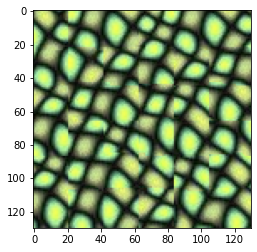

In [7]:
import cv2
import matplotlib.pyplot as plt2
img = cv2.imread('todo.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt2.imshow(img)
print(img.shape)
finalImage,overlapPlot = replicateImage(img, 25 , (6, 6),'todo',"Edmond",False,False)
plt2.imshow(finalImage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


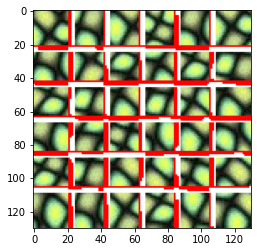

In [8]:
plt2.imshow(overlapPlot)

(157, 237, 3)
Shape of the input image (157, 237, 3)
Shape of the resultant image (310, 310, 3)


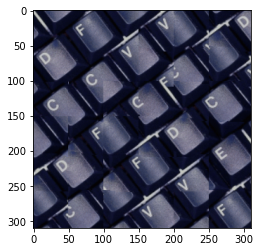

In [9]:
#might take a couples of minutes to finish the execution as the image is large
import cv2
import matplotlib.pyplot as plt
keyimg = cv2.imread('key.png')
keyimg = cv2.cvtColor(keyimg, cv2.COLOR_BGR2RGB)
plt.imshow(keyimg)
print(keyimg.shape)
keyimg,overlapImage = replicateImage(keyimg, 60, (6,6),'keyboard',"Edmond",False,False)
plt.imshow(keyimg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


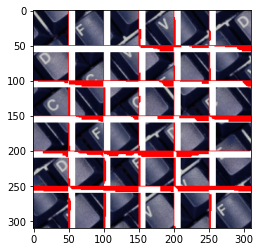

In [10]:
plt.imshow(overlapImage)

In [11]:
#To include in Readme
#In case of any attributes not found error in Edmons module, please restart the kernel so that the modules are reloaded

In [12]:
import cv2
import matplotlib.pyplot as plt2

# Ford Algorithm Implementation

(64, 64, 3)
Shape of the input image (64, 64, 3)
Shape of the resultant image (130, 130, 3)


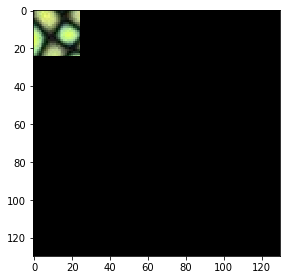

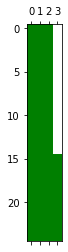

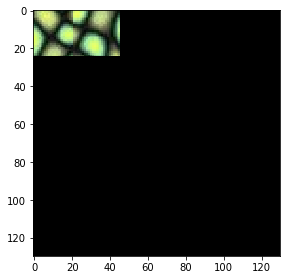

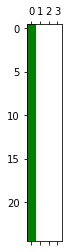

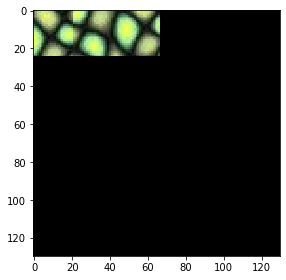

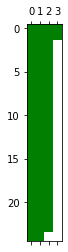

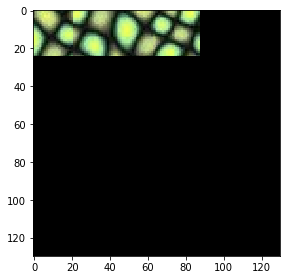

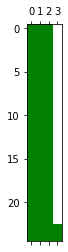

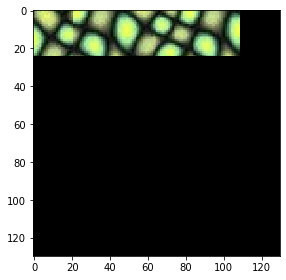

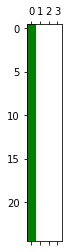

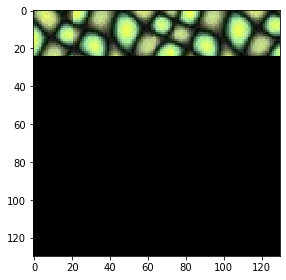

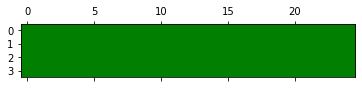

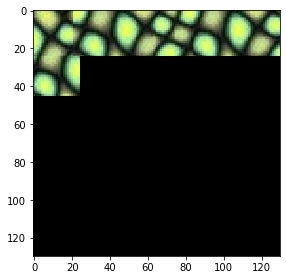

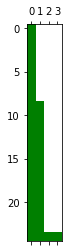

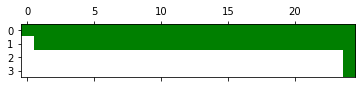

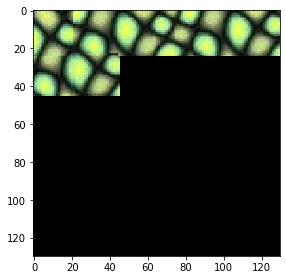

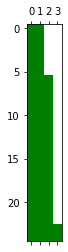

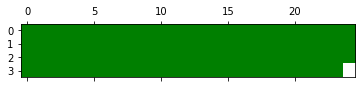

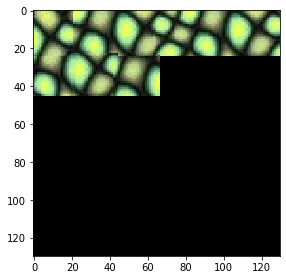

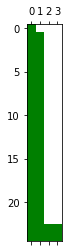

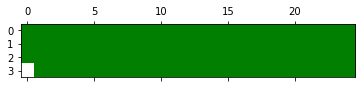

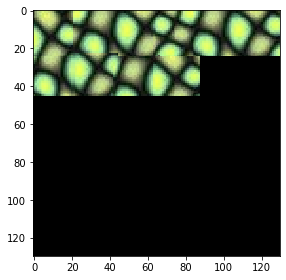

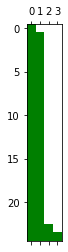

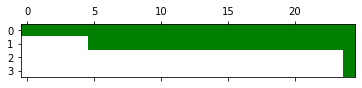

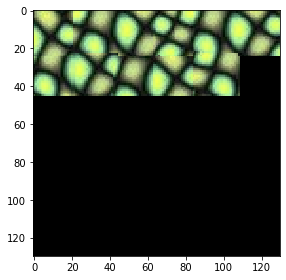

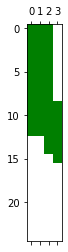

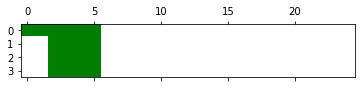

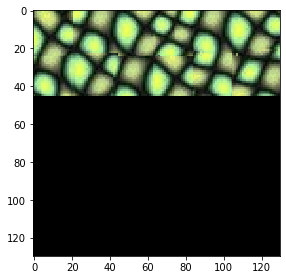

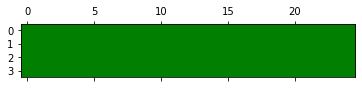

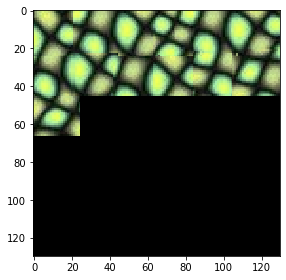

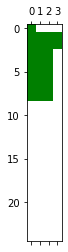

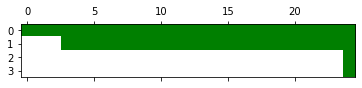

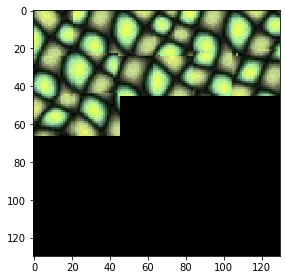

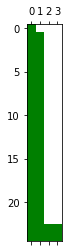

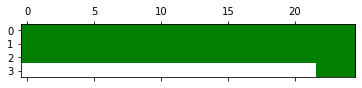

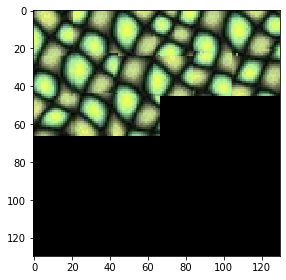

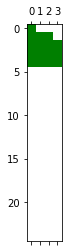

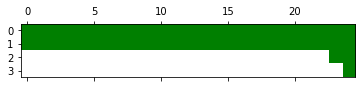

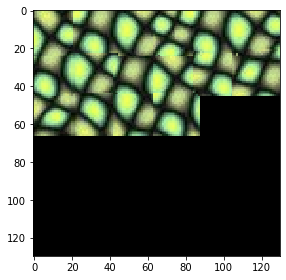

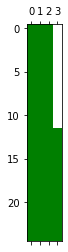

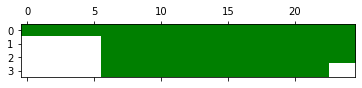

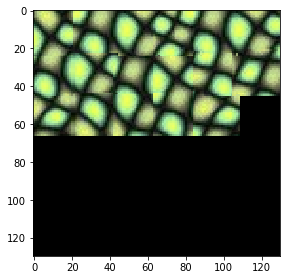

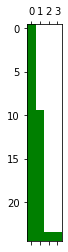

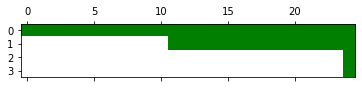

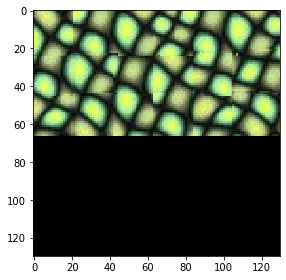

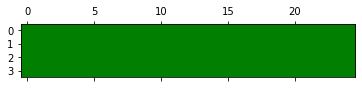

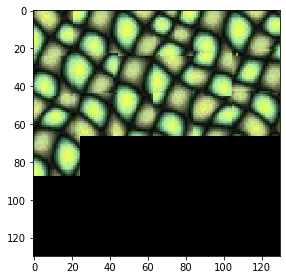

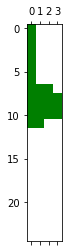

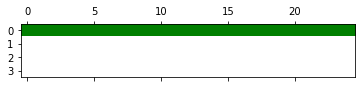

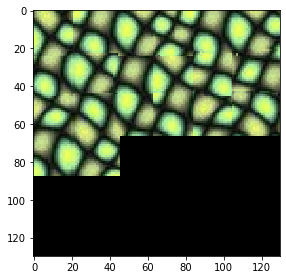

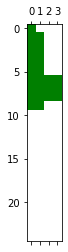

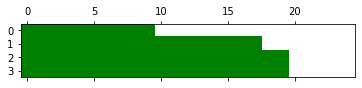

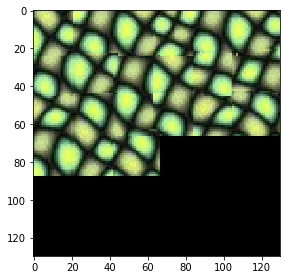

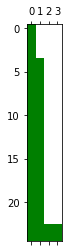

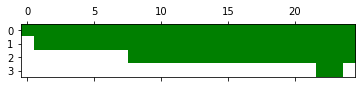

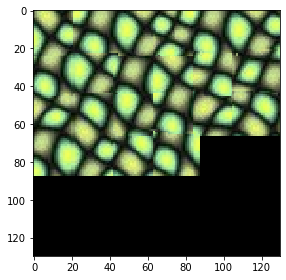

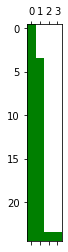

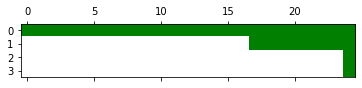

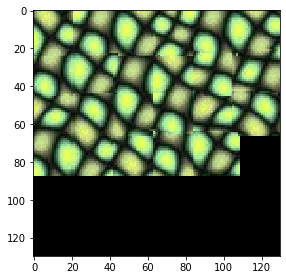

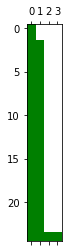

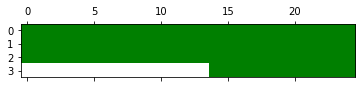

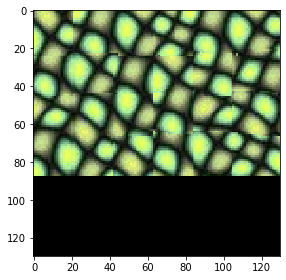

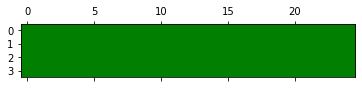

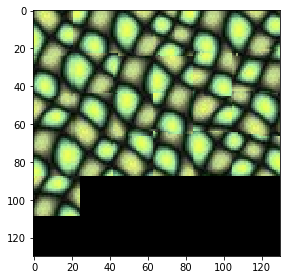

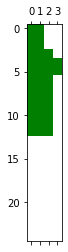

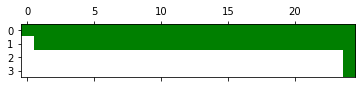

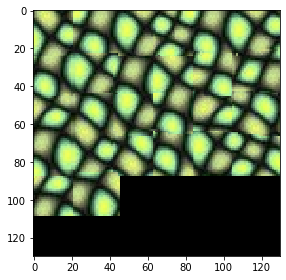

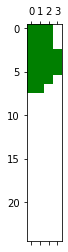

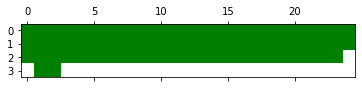

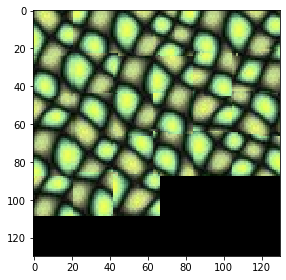

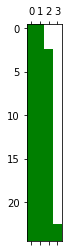

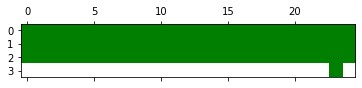

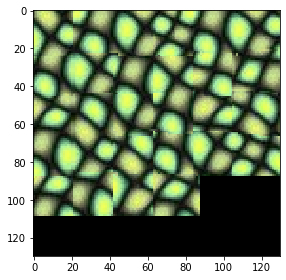

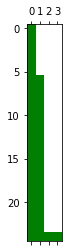

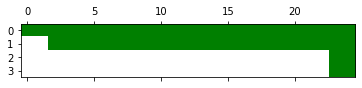

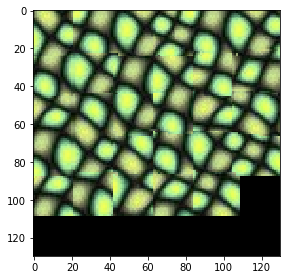

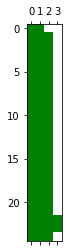

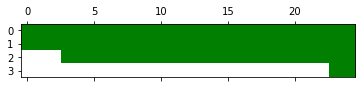

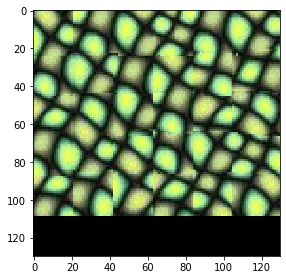

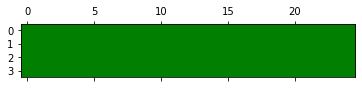

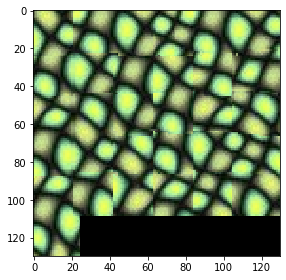

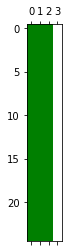

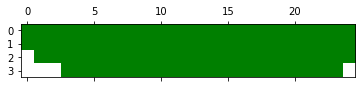

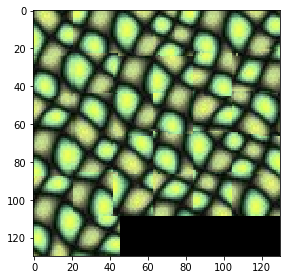

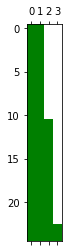

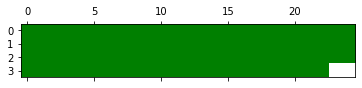

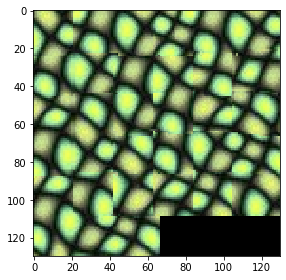

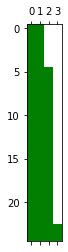

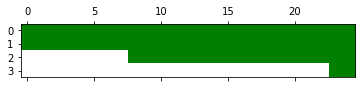

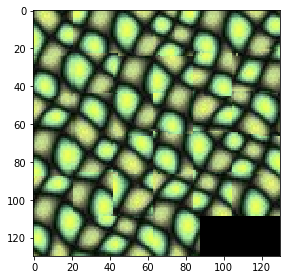

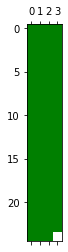

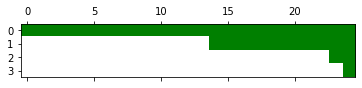

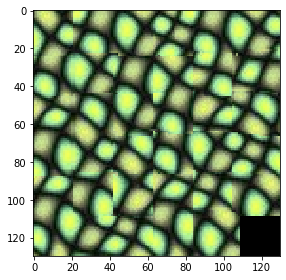

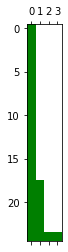

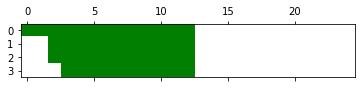

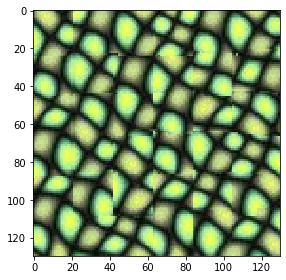

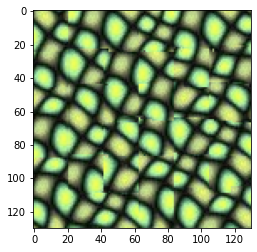

In [13]:
img = cv2.imread('todo.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt2.imshow(img)
print(img.shape)
finalImage,overlapPlot = replicateImage(img, 25 , (6, 6),'todo',"Ford",True,True)
plt2.imshow(finalImage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


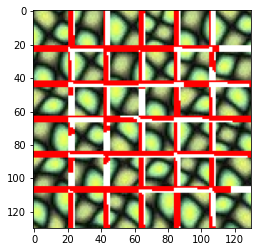

In [14]:
plt2.imshow(overlapPlot)

(157, 237, 3)
Shape of the input image (157, 237, 3)
Shape of the resultant image (310, 310, 3)


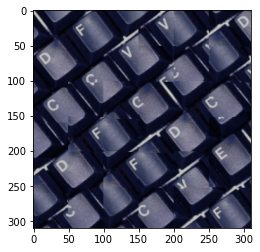

In [15]:
import cv2
import matplotlib.pyplot as plt2
img = cv2.imread('key.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt2.imshow(img)
print(img.shape)
finalImage,overlapPlot = replicateImage(img, 60 , (6, 6),'keyboard',"Ford",False,False)
plt2.imshow(finalImage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


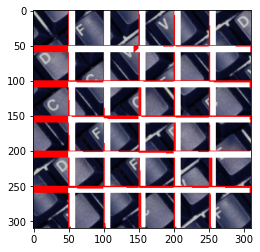

In [16]:
plt2.imshow(overlapPlot)

(217, 291, 3)
Shape of the input image (217, 291, 3)
Shape of the resultant image (365, 365, 3)


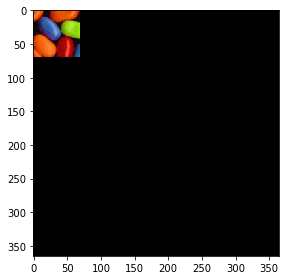

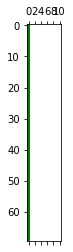

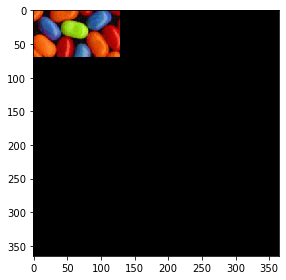

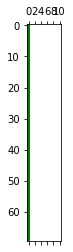

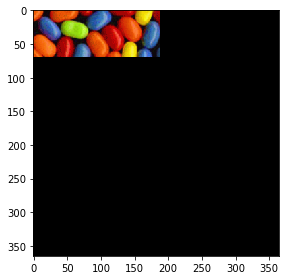

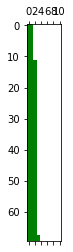

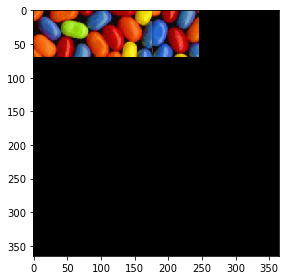

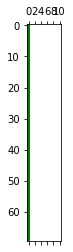

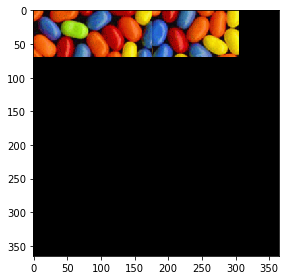

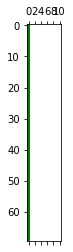

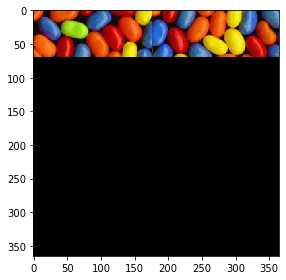

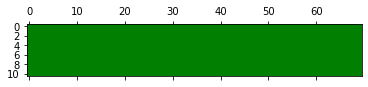

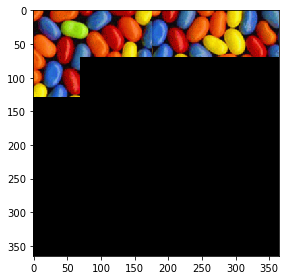

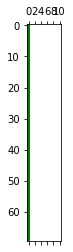

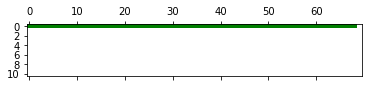

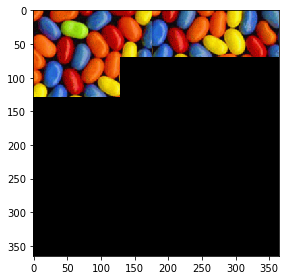

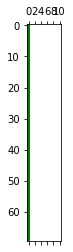

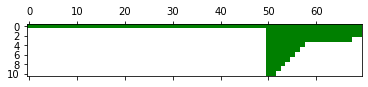

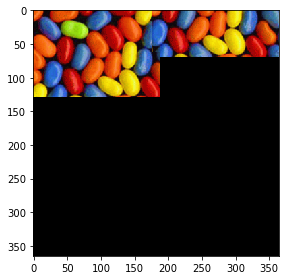

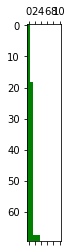

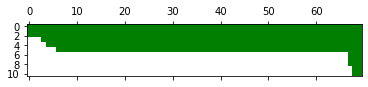

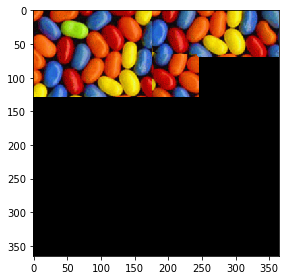

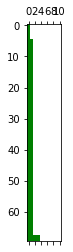

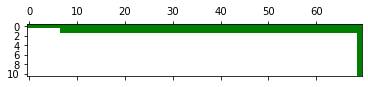

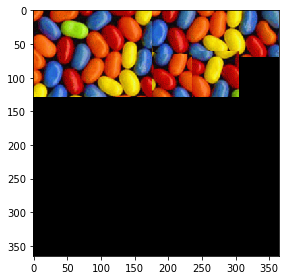

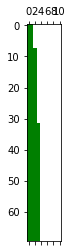

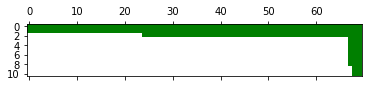

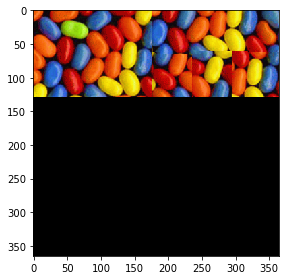

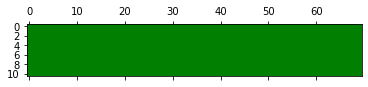

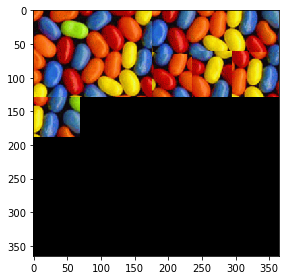

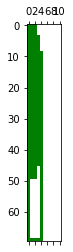

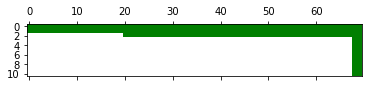

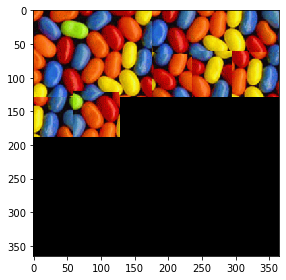

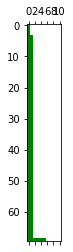

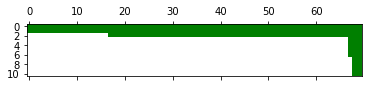

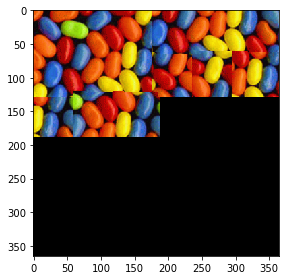

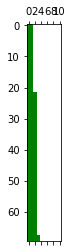

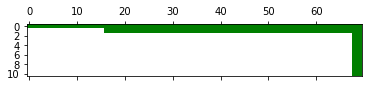

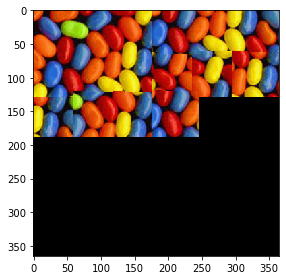

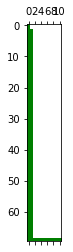

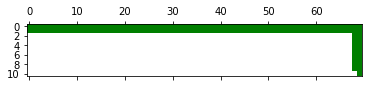

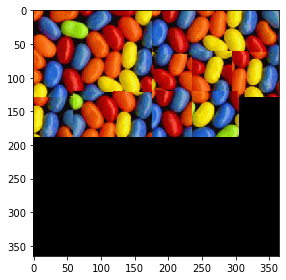

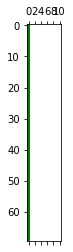

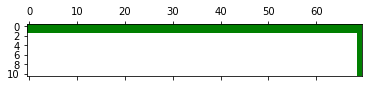

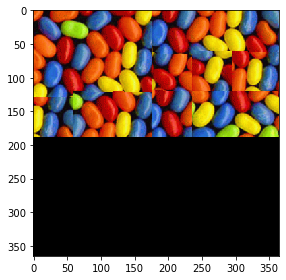

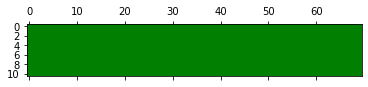

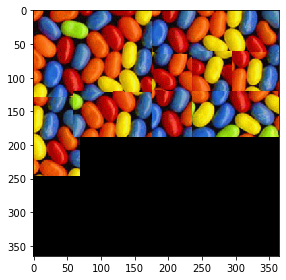

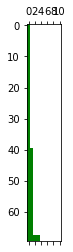

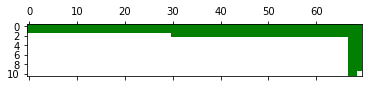

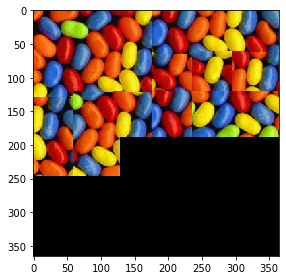

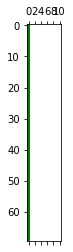

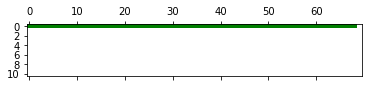

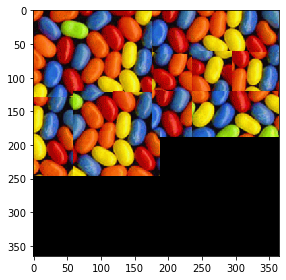

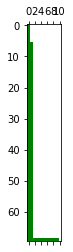

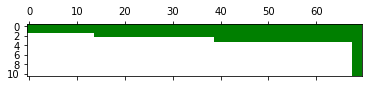

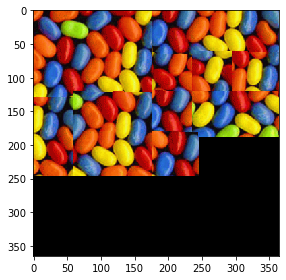

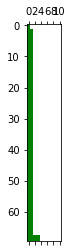

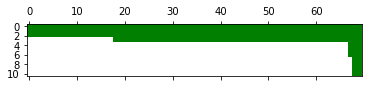

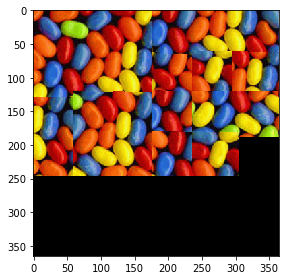

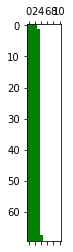

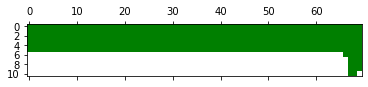

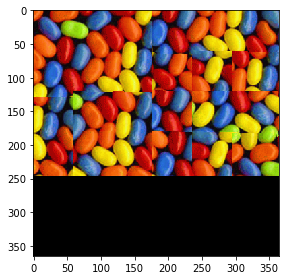

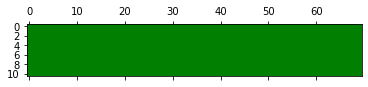

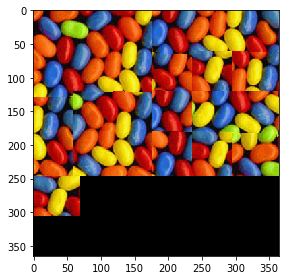

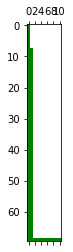

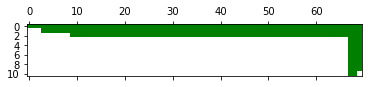

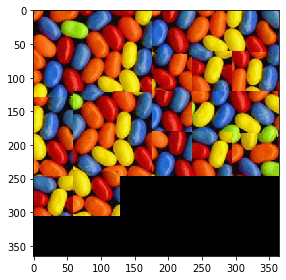

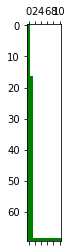

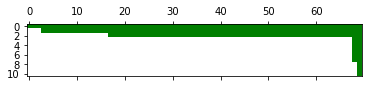

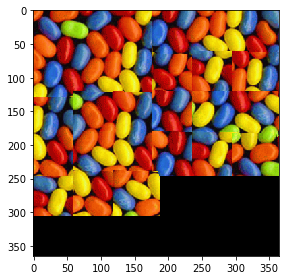

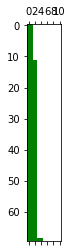

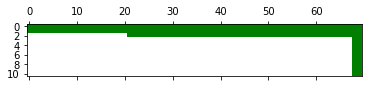

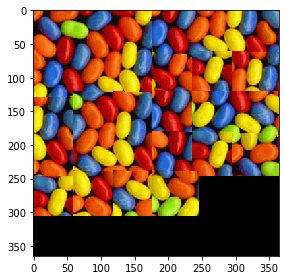

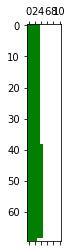

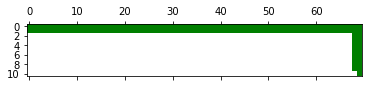

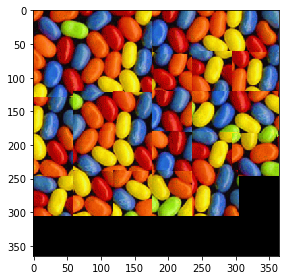

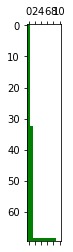

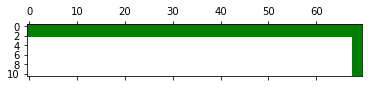

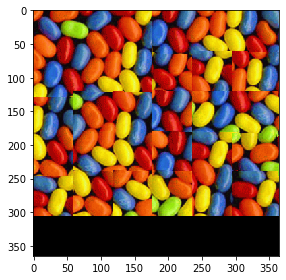

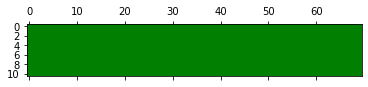

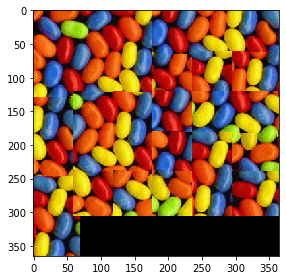

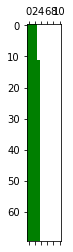

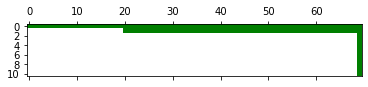

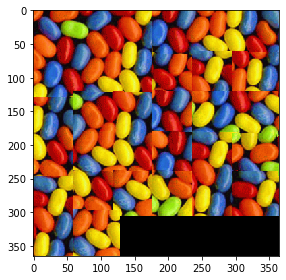

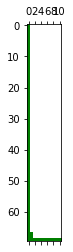

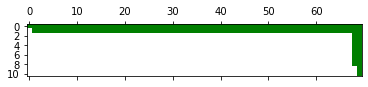

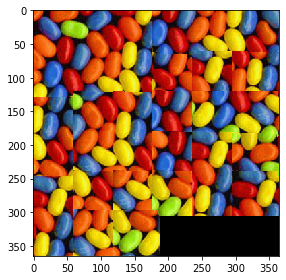

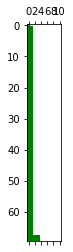

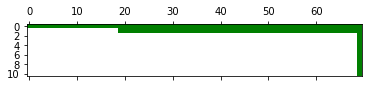

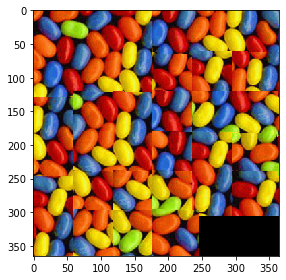

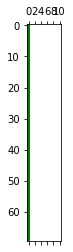

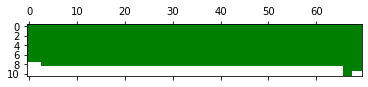

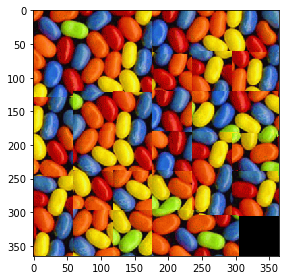

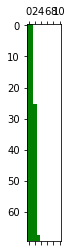

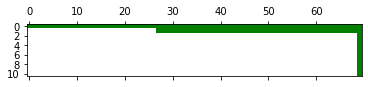

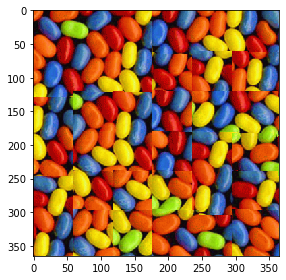

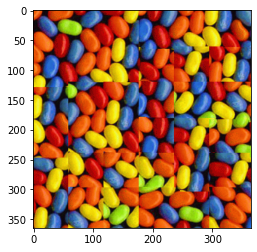

In [17]:
#might take some time to run
import cv2
import matplotlib.pyplot as plt2
bottlesimg = cv2.imread('jelly.png')
bottlesimg = cv2.cvtColor(bottlesimg, cv2.COLOR_BGR2RGB)
plt2.imshow(bottlesimg)
print(bottlesimg.shape)
finalBottleImage,overlapPlotBottles = replicateImage(bottlesimg, 70 , (6, 6),'jelly',"Ford",True,True)
plt2.imshow(finalBottleImage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


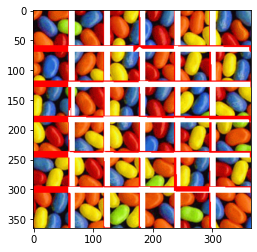

In [18]:
plt2.imshow(overlapPlotBottles)